In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional
import gymnasium as gym
from abc import ABC, abstractmethod
import pandas as pd
import seaborn as sns

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# PART 1: MULTI-ARMED BANDITS

## 1.1 Custom Multi-Armed Bandit Environment

In [3]:
class MultiArmedBandit:
    """
    Custom Multi-Armed Bandit environment following Gymnasium API structure.

    Each arm has a Gaussian reward distribution with:
    - Mean: sampled from N(0, 1)
    - Variance: 1

    This follows the "10-armed testbed" from Sutton & Barto Section 2.2.
    """

    def __init__(self, n_arms: int = 10, seed: Optional[int] = None):
        """
        Initialize the bandit environment.

        Args:
            n_arms: Number of bandit arms
            seed: Random seed for reproducibility
        """
        self.n_arms = n_arms
        self.rng = np.random.RandomState(seed)

        # True action values q*(a) - sampled from N(0, 1)
        self.q_true = self.rng.randn(n_arms)

        # Track optimal action
        self.optimal_action = np.argmax(self.q_true)

        # Environment state
        self.step_count = 0

    def reset(self) -> Tuple[None, dict]:
        """
        Reset the environment (following Gymnasium API).

        Returns:
            observation: None (bandits have no state)
            info: Dictionary with environment information
        """
        self.step_count = 0
        info = {
            'q_true': self.q_true.copy(),
            'optimal_action': self.optimal_action
        }
        return None, info

    def step(self, action: int) -> Tuple[None, float, bool, bool, dict]:
        """
        Take an action and receive reward (following Gymnasium API).

        Args:
            action: Selected arm (0 to n_arms-1)

        Returns:
            observation: None (bandits have no state)
            reward: Sampled reward R_t
            terminated: Always False (continuing task)
            truncated: Always False
            info: Dictionary with step information
        """
        assert 0 <= action < self.n_arms, f"Invalid action: {action}"

        # Sample reward from N(q*(a), 1)
        reward = self.rng.randn() + self.q_true[action]

        self.step_count += 1

        info = {
            'optimal_action_taken': action == self.optimal_action,
            'q_true_selected': self.q_true[action]
        }

        return None, reward, False, False, info

    def get_optimal_value(self) -> float:
        """Return the value of the optimal action."""
        return np.max(self.q_true)

## 1.2 Agent Base Class


In [4]:
class BanditAgent(ABC):
    """Abstract base class for bandit algorithms."""

    def __init__(self, n_arms: int):
        self.n_arms = n_arms
        self.reset()

    def reset(self):
        """Reset agent statistics."""
        self.Q = np.zeros(self.n_arms)  # Estimated action values
        self.N = np.zeros(self.n_arms)  # Action counts
        self.step_count = 0

    @abstractmethod
    def select_action(self) -> int:
        """Select an action based on the algorithm."""
        pass

    def update(self, action: int, reward: float):
        """
        Update action-value estimates using incremental implementation.

        Uses the sample-average method (Equation 2.3 from Sutton & Barto):
        Q_{n+1} = Q_n + (1/n)[R_n - Q_n]
        """
        self.N[action] += 1
        self.step_count += 1

        # Incremental update (Equation 2.3)
        step_size = 1.0 / self.N[action]
        self.Q[action] += step_size * (reward - self.Q[action])

## 1.3 ε-Greedy Agent

In [5]:
class EpsilonGreedyAgent(BanditAgent):
    """
    ε-greedy action selection (Section 2.2).

    With probability ε, select a random action (exploration).
    With probability 1-ε, select the greedy action (exploitation).
    """

    def __init__(self, n_arms: int, epsilon: float):
        self.epsilon = epsilon
        super().__init__(n_arms)

    def select_action(self) -> int:
        """Select action using ε-greedy strategy."""
        if np.random.random() < self.epsilon:
            # Explore: random action
            return np.random.randint(self.n_arms)
        else:
            # Exploit: greedy action (break ties randomly)
            return np.random.choice(np.flatnonzero(self.Q == self.Q.max()))

    def __repr__(self):
        return f"ε-greedy (ε={self.epsilon})"

## 1.4 UCB Agent

In [6]:
class UCBAgent(BanditAgent):
    """
    Upper Confidence Bound action selection (Section 2.6).

    Selects actions according to:
    A_t = argmax_a [Q_t(a) + c * sqrt(ln(t) / N_t(a))]

    The square-root term is a measure of uncertainty.
    """

    def __init__(self, n_arms: int, c: float = 2.0):
        self.c = c
        super().__init__(n_arms)

    def select_action(self) -> int:
        """Select action using UCB strategy (Equation 2.8)."""
        # First, try each action once
        if self.step_count < self.n_arms:
            return self.step_count

        # UCB action selection
        ucb_values = self.Q + self.c * np.sqrt(
            np.log(self.step_count) / self.N
        )

        # Break ties randomly
        return np.random.choice(np.flatnonzero(ucb_values == ucb_values.max()))

    def __repr__(self):
        return f"UCB (c={self.c})"

## 1.5 Experiment Runner

In [7]:
def run_bandit_experiment(
    agent: BanditAgent,
    n_steps: int = 2000,
    n_runs: int = 1000
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Run bandit experiment over multiple independent runs.

    Args:
        agent: Bandit agent (ε-greedy or UCB)
        n_steps: Number of time steps per run
        n_runs: Number of independent runs

    Returns:
        avg_rewards: Average reward at each time step [n_steps]
        optimal_actions: % optimal action at each time step [n_steps]
    """
    all_rewards = np.zeros((n_runs, n_steps))
    all_optimal = np.zeros((n_runs, n_steps))

    for run in range(n_runs):
        # Create new bandit problem for this run
        bandit = MultiArmedBandit(n_arms=10, seed=run)
        _, info = bandit.reset()

        # Reset agent
        agent.reset()

        # Run episode
        for step in range(n_steps):
            action = agent.select_action()
            _, reward, _, _, step_info = bandit.step(action)
            agent.update(action, reward)

            all_rewards[run, step] = reward
            all_optimal[run, step] = step_info['optimal_action_taken']

    # Average over runs
    avg_rewards = all_rewards.mean(axis=0)
    optimal_actions = all_optimal.mean(axis=0) * 100  # Convert to percentage

    return avg_rewards, optimal_actions

In [8]:
print("Running Multi-Armed Bandit Experiments...")

# Define agents to compare
agents = [
    EpsilonGreedyAgent(n_arms=10, epsilon=0.0),   # Greedy
    EpsilonGreedyAgent(n_arms=10, epsilon=0.01),
    EpsilonGreedyAgent(n_arms=10, epsilon=0.1),
    EpsilonGreedyAgent(n_arms=10, epsilon=0.2),
    UCBAgent(n_arms=10, c=1.0),
    UCBAgent(n_arms=10, c=2.0),
]

results = {}
for agent in agents:
    print(f"Testing {agent}...")
    avg_rewards, optimal_actions = run_bandit_experiment(
        agent, n_steps=2000, n_runs=1000
    )
    results[str(agent)] = {
        'rewards': avg_rewards,
        'optimal': optimal_actions
    }

print("Experiments complete!")

Running Multi-Armed Bandit Experiments...
Testing ε-greedy (ε=0.0)...
Testing ε-greedy (ε=0.01)...
Testing ε-greedy (ε=0.1)...
Testing ε-greedy (ε=0.2)...
Testing UCB (c=1.0)...
Testing UCB (c=2.0)...
Experiments complete!


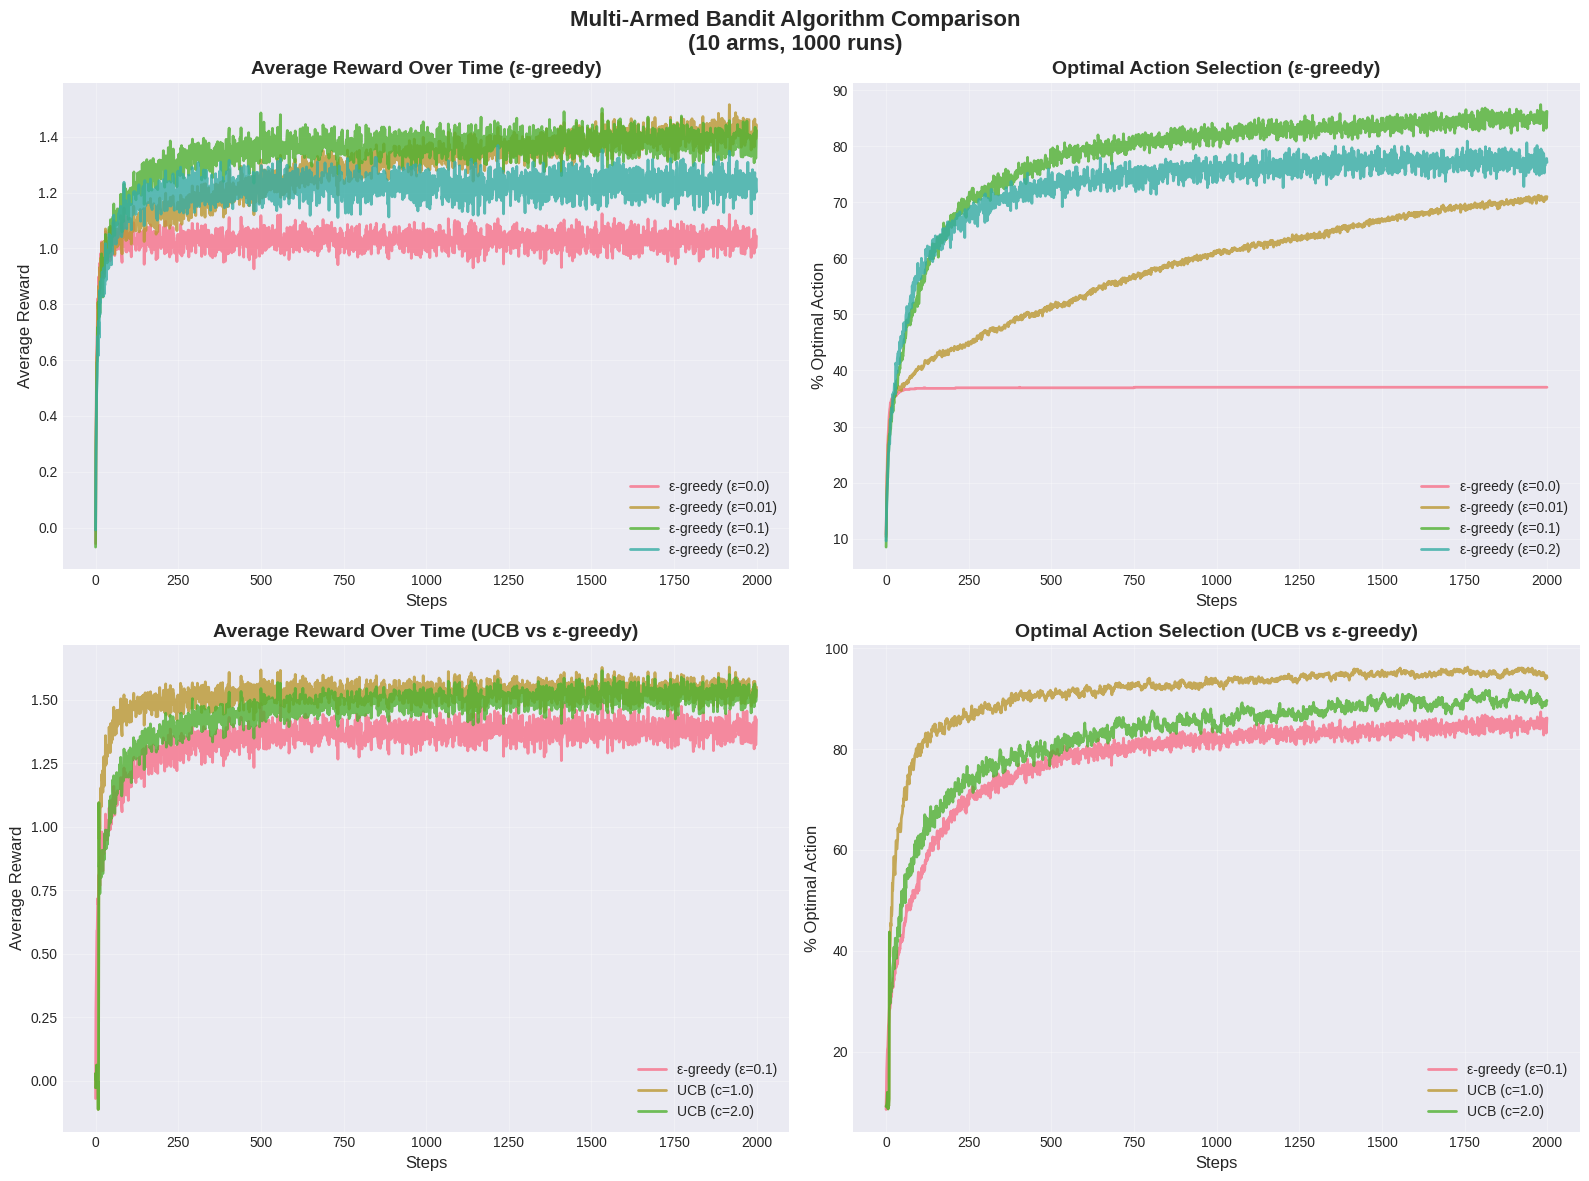

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Multi-Armed Bandit Algorithm Comparison\n(10 arms, 1000 runs)',
             fontsize=16, fontweight='bold')

# --- Plot 1: Average Reward (ε-greedy) ---
ax1 = axes[0, 0]
for agent_name, data in results.items():
    if 'ε-greedy' in agent_name:
        ax1.plot(data['rewards'], label=agent_name, linewidth=2, alpha=0.8)

ax1.set_xlabel('Steps', fontsize=12)
ax1.set_ylabel('Average Reward', fontsize=12)
ax1.set_title('Average Reward Over Time (ε-greedy)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# --- Plot 2: Optimal Action % (ε-greedy) ---
ax2 = axes[0, 1]
for agent_name, data in results.items():
    if 'ε-greedy' in agent_name:
        ax2.plot(data['optimal'], label=agent_name, linewidth=2, alpha=0.8)

ax2.set_xlabel('Steps', fontsize=12)
ax2.set_ylabel('% Optimal Action', fontsize=12)
ax2.set_title('Optimal Action Selection (ε-greedy)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# --- Plot 3: Average Reward (UCB) ---
ax3 = axes[1, 0]
for agent_name, data in results.items():
    if 'UCB' in agent_name or agent_name == 'ε-greedy (ε=0.1)':
        ax3.plot(data['rewards'], label=agent_name, linewidth=2, alpha=0.8)

ax3.set_xlabel('Steps', fontsize=12)
ax3.set_ylabel('Average Reward', fontsize=12)
ax3.set_title('Average Reward Over Time (UCB vs ε-greedy)', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# --- Plot 4: Optimal Action % (UCB) ---
ax4 = axes[1, 1]
for agent_name, data in results.items():
    if 'UCB' in agent_name or agent_name == 'ε-greedy (ε=0.1)':
        ax4.plot(data['optimal'], label=agent_name, linewidth=2, alpha=0.8)

ax4.set_xlabel('Steps', fontsize=12)
ax4.set_ylabel('% Optimal Action', fontsize=12)
ax4.set_title('Optimal Action Selection (UCB vs ε-greedy)', fontsize=14, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
print("SUMMARY STATISTICS (Final 100 steps)")

summary_data = []
for agent_name, data in results.items():
    final_reward = data['rewards'][-100:].mean()
    final_optimal = data['optimal'][-100:].mean()
    summary_data.append({
        'Agent': agent_name,
        'Avg Reward': f"{final_reward:.3f}",
        '% Optimal': f"{final_optimal:.1f}%"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

SUMMARY STATISTICS (Final 100 steps)
            Agent Avg Reward % Optimal
 ε-greedy (ε=0.0)      1.030     37.0%
ε-greedy (ε=0.01)      1.418     70.5%
 ε-greedy (ε=0.1)      1.382     84.9%
 ε-greedy (ε=0.2)      1.230     77.1%
      UCB (c=1.0)      1.537     95.3%
      UCB (c=2.0)      1.517     90.0%


# PART 2: GYMNASIUM ENVIRONMENTS

## 2.1 Environment Inspection Utilities

In [23]:
def inspect_environment(env_name: str):
    """
    Inspect a Gymnasium environment and document its MDP structure.

    Maps to MDP tuple (S, A, R, P, γ):
    - S: Observation space
    - A: Action space
    - R: Reward structure
    - P: Transition dynamics (hidden in environment)
    - γ: Discount factor (task-dependent)
    """
    print(f"\n{'='*70}")
    print(f"ENVIRONMENT: {env_name}")
    print(f"{'='*70}\n")

    # Create environment
    env = gym.make(env_name)

    # Observation Space (States)
    print("📊 OBSERVATION SPACE (States - S)")
    print(f"   Type: {type(env.observation_space).__name__}")
    print(f"   Description: {env.observation_space}")

    if hasattr(env.observation_space, 'n'):
        print(f"   Number of states: {env.observation_space.n}")
        print(f"   State space: Discrete")
    else:
        print(f"   Shape: {env.observation_space.shape}")
        print(f"   Bounds: {env.observation_space.low} to {env.observation_space.high}")
        print(f"   State space: Continuous")

    # Action Space
    print(f"\n🎮 ACTION SPACE (Actions - A)")
    print(f"   Type: {type(env.action_space).__name__}")
    print(f"   Description: {env.action_space}")

    if hasattr(env.action_space, 'n'):
        print(f"   Number of actions: {env.action_space.n}")
        print(f"   Action space: Discrete")
        # Print action meanings if available
        if hasattr(env.unwrapped, 'get_action_meanings'):
            meanings = env.unwrapped.get_action_meanings()
            print(f"   Action meanings: {meanings}")
    else:
        print(f"   Shape: {env.action_space.shape}")
        print(f"   Bounds: {env.action_space.low} to {env.action_space.high}")
        print(f"   Action space: Continuous")

    # Reward Structure
    print(f"\n💰 REWARD STRUCTURE (R)")
    try:
        print(f"   Reward range: {env.reward_range}")
    except AttributeError:
        print(f"   Reward range: Not specified (environment-dependent)")

    # Additional Info
    print(f"\n📝 ADDITIONAL INFORMATION")
    if hasattr(env, 'spec'):
        print(f"   Max episode steps: {env.spec.max_episode_steps}")

    # Sample interaction
    print(f"\n🔬 SAMPLE INTERACTION")
    obs, info = env.reset(seed=42)
    print(f"   Initial observation: {obs}")

    action = env.action_space.sample()
    print(f"   Sample action: {action}")

    next_obs, reward, terminated, truncated, info = env.step(action)
    print(f"   Next observation: {next_obs}")
    print(f"   Reward: {reward}")
    print(f"   Terminated: {terminated}")
    print(f"   Truncated: {truncated}")

    # MDP Mapping Summary
    print(f"\n🎯 MDP TUPLE MAPPING")
    print(f"   S (States): {type(env.observation_space).__name__}")
    print(f"   A (Actions): {type(env.action_space).__name__}")
    print(f"   R (Rewards): Defined by environment dynamics")
    print(f"   P (Transitions): Hidden in env.step() method")
    print(f"   γ (Discount): Task-dependent (typically 0.99)")

    env.close()
    return env

## 2.2 Random Policy Agent

In [29]:
class RandomPolicyAgent:
    """Agent that selects actions uniformly at random."""

    def __init__(self, action_space):
        self.action_space = action_space
        self.name = "Random"

    def select_action(self, observation):
        return self.action_space.sample()

    def reset(self):
        pass

In [30]:
def evaluate_agent(
    env_name: str,
    agent,
    n_episodes: int = 100,
    seed: int = 42,
    verbose: bool = False
) -> dict:
    """Evaluate agent performance over multiple episodes."""
    env = gym.make(env_name)

    episode_returns = []
    episode_lengths = []
    success_count = 0
    reward_history = []

    for episode in range(n_episodes):
        obs, info = env.reset(seed=seed + episode)
        agent.reset()

        episode_return = 0
        episode_length = 0
        terminated = False
        truncated = False
        episode_rewards = []

        while not (terminated or truncated):
            action = agent.select_action(obs)
            obs, reward, terminated, truncated, info = env.step(action)

            episode_return += reward
            episode_length += 1
            episode_rewards.append(reward)

            # Safety check for infinite loops
            if episode_length > 1000:
                break

        episode_returns.append(episode_return)
        episode_lengths.append(episode_length)
        reward_history.append(episode_rewards)

        # Check for success (environment-specific)
        if episode_return > 0:
            success_count += 1

        if verbose and episode < 5:
            print(f"   Episode {episode}: Return={episode_return:.1f}, Length={episode_length}")

    env.close()

    return {
        'agent_name': agent.name,
        'mean_return': np.mean(episode_returns),
        'std_return': np.std(episode_returns),
        'mean_length': np.mean(episode_lengths),
        'std_length': np.std(episode_lengths),
        'success_rate': success_count / n_episodes * 100,
        'returns': episode_returns,
        'lengths': episode_lengths
    }

## 2.3 Inspect Gymnasium Environments

In [31]:
print("PART 2: GYMNASIUM ENVIRONMENT EXPLORATION")

# Inspect FrozenLake
env_frozen = inspect_environment('FrozenLake-v1')

# Inspect Taxi
env_taxi = inspect_environment('Taxi-v3')

PART 2: GYMNASIUM ENVIRONMENT EXPLORATION

ENVIRONMENT: FrozenLake-v1

📊 OBSERVATION SPACE (States - S)
   Type: Discrete
   Description: Discrete(16)
   Number of states: 16
   State space: Discrete

🎮 ACTION SPACE (Actions - A)
   Type: Discrete
   Description: Discrete(4)
   Number of actions: 4
   Action space: Discrete

💰 REWARD STRUCTURE (R)
   Reward range: Not specified (environment-dependent)

📝 ADDITIONAL INFORMATION
   Max episode steps: 100

🔬 SAMPLE INTERACTION
   Initial observation: 0
   Sample action: 0
   Next observation: 0
   Reward: 0
   Terminated: False
   Truncated: False

🎯 MDP TUPLE MAPPING
   S (States): Discrete
   A (Actions): Discrete
   R (Rewards): Defined by environment dynamics
   P (Transitions): Hidden in env.step() method
   γ (Discount): Task-dependent (typically 0.99)

ENVIRONMENT: Taxi-v3

📊 OBSERVATION SPACE (States - S)
   Type: Discrete
   Description: Discrete(500)
   Number of states: 500
   State space: Discrete

🎮 ACTION SPACE (Actions - A)

## 2.4 Evaluate Random Policy

In [32]:
print("RANDOM POLICY EVALUATION")

# Evaluate on FrozenLake
print("🧊 FrozenLake-v1")
frozen_agent = RandomPolicyAgent(env_frozen.action_space)
frozen_results = evaluate_agent('FrozenLake-v1', frozen_agent, n_episodes=1000)

print(f"   Mean Return: {frozen_results['mean_return']:.3f} ± {frozen_results['std_return']:.3f}")
print(f"   Mean Episode Length: {frozen_results['mean_length']:.1f} ± {frozen_results['std_length']:.1f}")
print(f"   Success Rate: {frozen_results['success_rate']:.1f}%")

# Evaluate on Taxi
print("🚕 Taxi-v3")
taxi_agent = RandomPolicyAgent(env_taxi.action_space)
taxi_results = evaluate_agent('Taxi-v3', taxi_agent, n_episodes=1000)

print(f"   Mean Return: {taxi_results['mean_return']:.3f} ± {taxi_results['std_return']:.3f}")
print(f"   Mean Episode Length: {taxi_results['mean_length']:.1f} ± {taxi_results['std_length']:.1f}")
print(f"   Success Rate: {taxi_results['success_rate']:.1f}%")

RANDOM POLICY EVALUATION
🧊 FrozenLake-v1
   Mean Return: 0.012 ± 0.109
   Mean Episode Length: 7.8 ± 5.7
   Success Rate: 1.2%
🚕 Taxi-v3
   Mean Return: -772.859 ± 100.591
   Mean Episode Length: 196.6 ± 18.4
   Success Rate: 0.0%


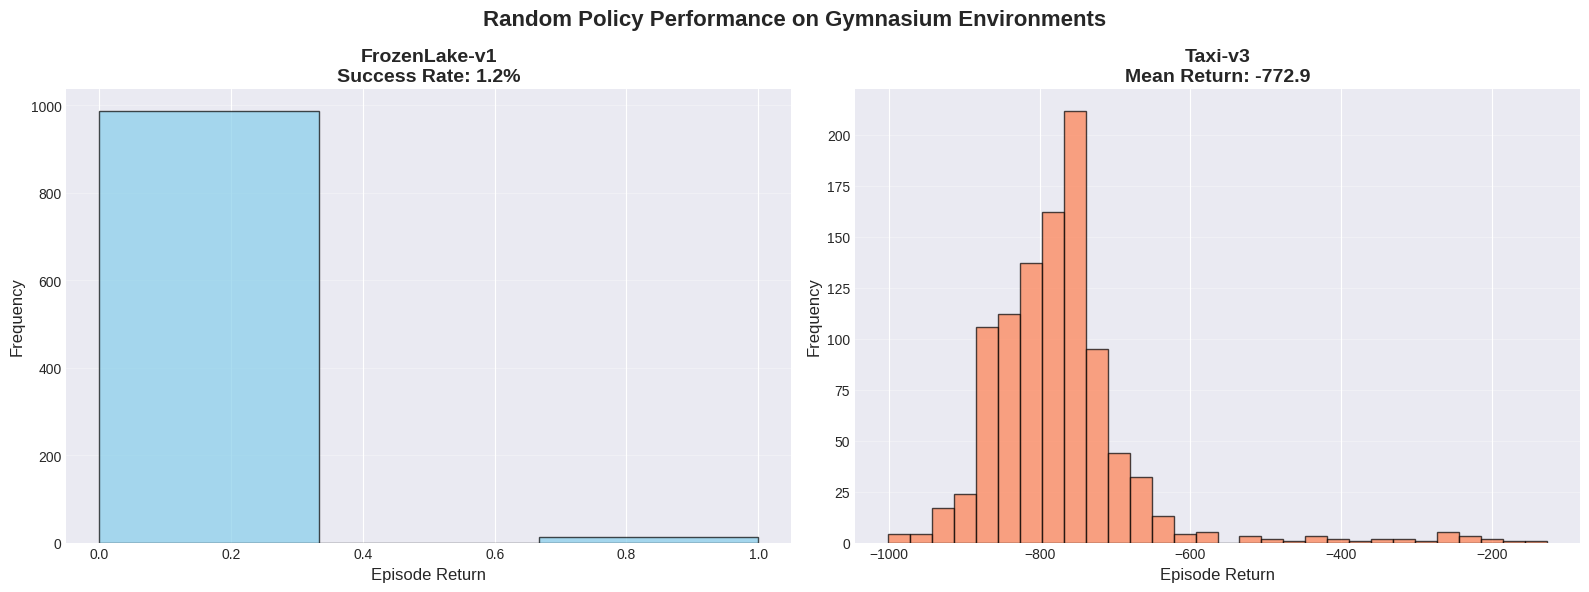

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Random Policy Performance on Gymnasium Environments',
             fontsize=16, fontweight='bold')

# FrozenLake histogram
ax1 = axes[0]
ax1.hist(frozen_results['returns'], bins=3, edgecolor='black', alpha=0.7, color='skyblue')
ax1.set_xlabel('Episode Return', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title(f'FrozenLake-v1\nSuccess Rate: {frozen_results["success_rate"]:.1f}%',
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Taxi histogram
ax2 = axes[1]
ax2.hist(taxi_results['returns'], bins=30, edgecolor='black', alpha=0.7, color='coral')
ax2.set_xlabel('Episode Return', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title(f'Taxi-v3\nMean Return: {taxi_results["mean_return"]:.1f}',
              fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()